In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
import pickle
import csv
import itertools
from collections import defaultdict
import time
import pandas as pd
import math
from tqdm import tqdm
import dill

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

### MNIST

![](https://nthu-datalab.github.io/ml/labs/11-1_CNN/imgsrc/MNIST.png)

![](https://nthu-datalab.github.io/ml/labs/11-1_CNN/imgsrc/MNIST2.png)

In [9]:
# Download and prepare the MNIST dataset
(train_image, train_label), (test_image, test_label) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_image, test_image = train_image / 255.0, test_image / 255.0
print('shape of train_image:', train_image.shape)
print('shape of train_label:', train_label.shape)

shape of train_image: (60000, 28, 28)
shape of train_label: (60000,)


#### Softmax Regession on MNIST

In [10]:
# flating the training data for dense layers
train_image_1 = train_image.reshape((60000, -1))
test_image_1 = test_image.reshape((10000, -1))
print(train_image_1.shape)
print(test_image_1.shape)

(60000, 784)
(10000, 784)


In [11]:
model_1 = models.Sequential()
model_1.add(layers.Dense(10, activation='softmax',input_shape=(784,)))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [12]:
# compile the model and train it for 5 epochs
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_1.fit(train_image_1, train_label, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4705 - accuracy: 0.8763
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3036 - accuracy: 0.9148
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2834 - accuracy: 0.9209
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2729 - accuracy: 0.9240
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2670 - accuracy: 0.9254


In [13]:
_, test_acc_1 = model_1.evaluate(test_image_1, test_label, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_1)

Testing Accuracy : 0.9245


### Multilayer Convolutional Network on MNIST

In [14]:
# reshaping the training data to 3 dimensions
train_image_2 = train_image.reshape((60000, 28, 28, 1))
test_image_2 = test_image.reshape((10000, 28, 28, 1))
print(train_image_2.shape)
print(test_image_2.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#### Create the convolutional base

In [15]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(28, 28, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation='relu'))

In [16]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


#### Add Dense layers on top

In [17]:
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(10, activation='softmax'))

In [18]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

#### Compile and train the model

In [19]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.fit(train_image_2, train_label, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 6ms/step - loss: 0.2553 - accuracy: 0.9227
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0861 - accuracy: 0.9765
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0634 - accuracy: 0.9825
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0467 - accuracy: 0.9870
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0397 - accuracy: 0.9884


### Cifar-10

![](https://nthu-datalab.github.io/ml/labs/11-1_CNN/imgsrc/CIFAR10.png)

In [20]:
# Loading Data

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# convert class vectors to binary vectors
Y_train = utils.to_categorical(y_train)
Y_test = utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

170500096/170498071 [==============================] - 19s 0us/step
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


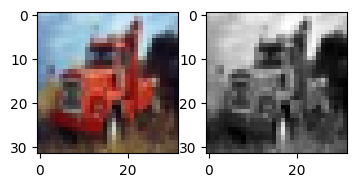

In [21]:
# transform a 3-channel image into one channel
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# plot a randomly chosen image
img = round(np.random.rand() * X_train.shape[0])
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(
    X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

#### Feature Selection

In [22]:
def getHOGfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy, sz = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = np.zeros((sx, sy), dtype=np.double)
    gy = np.zeros((sx, sy), dtype=np.double)
    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.double)
    for i in range(1, sx - 1):
        for j in range(1, sy - 1):
            gx[i, j] = image[i, j - 1] - image[i, j + 1]
            gy[i, j] = image[i + 1, j] - image[i - 1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
            hist_block = np.zeros(32, dtype=np.double)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
                    hist_cell = np.zeros(8, dtype=np.double)
                    for i in range(cy):
                        for j in range(cx):
                            n = int(cell[i, j, 0] / 45)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(
                hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel()

In [23]:
X_train_hog = []
X_test_hog = []

print('This will take some minutes.')

for img in tqdm(X_train_gray):
    img_hog = getHOGfeat(img)
    X_train_hog.append(img_hog)

for img in tqdm(X_test_gray):
    img_hog = getHOGfeat(img)
    X_test_hog.append(img_hog)
    
X_train_hog_array = np.asarray(X_train_hog)
X_test_hog_array = np.asarray(X_test_hog)

This will take some minutes.


100%|██████████| 10000/10000 [01:24<00:00, 118.40it/s]


### K Nearest Neighbors (KNN) on CIFAR-10

In [24]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_hog_array, y_train.ravel())
y_pred = knn.predict(X_test_hog_array)
print('[KNN]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[KNN]
Misclassified samples: 5334
Accuracy: 0.47


#### Support Vector Machine (SVM) on CIFAR-10

In [25]:
# SVM
from sklearn.svm import SVC 

print('This will take some minutes.')
start_time = time.time()

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_linear = SVC(kernel='linear', random_state=0, gamma=0.2, C=10.0)

svm_linear.fit(X_train_hog_array, y_train.ravel())
y_pred = svm_linear.predict(X_test_hog_array)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test.ravel(), y_pred))

print('{:.2f} sec.'.format(time.time()-start_time))

This will take some minutes.
[Linear SVC]
Misclassified samples: 4940
Accuracy: 0.51
829.84 sec.


#### CNN on CIFAR-10

In [26]:
model_3 = models.Sequential()

#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
                
model_3.add(layers.Flatten())
model_3.add(layers.Dense(384, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(192, activation='relu'))
model_3.add(layers.Dense(10, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [27]:
model_3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)
_, test_acc_3 = model_3.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_3)

Epoch 1/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.5842 - accuracy: 0.4405 - val_loss: 1.2480 - val_accuracy: 0.5696
Epoch 2/5
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1180 - accuracy: 0.6065 - val_loss: 1.0655 - val_accuracy: 0.6276
Epoch 3/5
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9373 - accuracy: 0.6756 - val_loss: 0.8441 - val_accuracy: 0.7072
Epoch 4/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8198 - accuracy: 0.7170 - val_loss: 0.9551 - val_accuracy: 0.6781
Epoch 5/5
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7327 - accuracy: 0.7465 - val_loss: 0.9600 - val_accuracy: 0.6793
Testing Accuracy : 0.6793


### Input Pipeline

#### Structure of an input pipeline

A typical TensorFlow training input pipeline can be framed as an ETL process:

1. Extract: Read data from memory (NumPy) or persistent storage -- either local (HDD or SSD) or remote (e.g. GCS or HDFS).
2. Transform: Use CPU to parse and perform preprocessing operations on the data such as shuffling, batching, and domain specific transformations such as image decompression and augmentation, text vectorization, or video temporal sampling.
3. Load: Load the transformed data onto the accelerator device(s) (e.g. GPU(s) or TPU(s)) that execute the machine learning model.

This pattern effectively utilizes the CPU, while reserving the accelerator for the heavy lifting of training your model. In addition, viewing input pipelines as an ETL process provides a framework that facilitates the application of performance optimizations.


#### tf.data API
To build a data input pipeline with tf.data, here are the steps that you can follow:

1. Define data source and initialize your Dataset object
2. Apply transformations on the dataset, following are some common useful techniques
    - map
    - shuffle
    - batch
    - repeat
    - prefetch
3. Create iterator


#### Construct your Dataset

In [28]:
# number of samples
n_samples = 200

# an array with shape (n_samples, 5)
raw_data_a = np.random.rand(n_samples, 5)
# a list with length of n_samples from 0 to n_samples-1
raw_data_b = np.arange(n_samples)
print(raw_data_a.shape, raw_data_b.shape)

(200, 5) (200,)


In [29]:
# this tells the dataset that each row of raw_data_a is corresponding to each element of raw_data_b
raw_dataset = tf.data.Dataset.from_tensor_slices((raw_data_a, raw_data_b))

#### Consume elements

In [30]:
# Here, we print the first 8 batches.
for i,elem in enumerate(raw_dataset):
    print("Batch ", i, ", b are ", elem)
    if i==7:
        break

Batch  0 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.01365423, 0.85581462, 0.51040292, 0.31045467, 0.38540368])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
Batch  1 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.10791608, 0.48917603, 0.1926033 , 0.13803773, 0.72875232])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
Batch  2 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.72704881, 0.92856542, 0.2038931 , 0.36001462, 0.14057212])>, <tf.Tensor: shape=(), dtype=int32, numpy=2>)
Batch  3 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.6723939 , 0.28275128, 0.1835762 , 0.58160727, 0.92447781])>, <tf.Tensor: shape=(), dtype=int32, numpy=3>)
Batch  4 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.07473727, 0.4235206 , 0.69584754, 0.09818716, 0.37283048])>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
Batch  5 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.56477512, 0.66249414, 0.88847749

In [31]:
# Here, we print the first 8 batches.
it = iter(raw_dataset)
for i in range(8):
    print("Batch ", i, ", b are ", next(it))

Batch  0 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.01365423, 0.85581462, 0.51040292, 0.31045467, 0.38540368])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
Batch  1 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.10791608, 0.48917603, 0.1926033 , 0.13803773, 0.72875232])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
Batch  2 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.72704881, 0.92856542, 0.2038931 , 0.36001462, 0.14057212])>, <tf.Tensor: shape=(), dtype=int32, numpy=2>)
Batch  3 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.6723939 , 0.28275128, 0.1835762 , 0.58160727, 0.92447781])>, <tf.Tensor: shape=(), dtype=int32, numpy=3>)
Batch  4 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.07473727, 0.4235206 , 0.69584754, 0.09818716, 0.37283048])>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
Batch  5 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.56477512, 0.66249414, 0.88847749

#### Apply transformations

In [32]:
def preprocess_function(one_row_a, one_b):
    """
        Input: one slice of the dataset
        Output: modified slice
    """
    # Do some data preprocessing, you can also input filenames and load data in here
    # Here, we transform each row of raw_data_a to its sum and mean
    one_row_a = [tf.reduce_sum(one_row_a), tf.reduce_mean(one_row_a)]

    return one_row_a, one_b

raw_dataset = raw_dataset.map(preprocess_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [33]:
it = iter(raw_dataset)
for i in range(8):
    print("Batch ", i, ", b are ", next(it))

Batch  0 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.07573013, 0.41514603])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
Batch  1 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.65648546, 0.33129709])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
Batch  2 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.36009408, 0.47201882])>, <tf.Tensor: shape=(), dtype=int32, numpy=2>)
Batch  3 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.64480645, 0.52896129])>, <tf.Tensor: shape=(), dtype=int32, numpy=3>)
Batch  4 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.66512305, 0.33302461])>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
Batch  5 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.88731413, 0.57746283])>, <tf.Tensor: shape=(), dtype=int32, numpy=5>)
Batch  6 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.58922683, 0.51784537])>, <tf.Tensor: shape=(), dtype=int32, numpy=6>)

In [34]:
# shuffle
dataset = raw_dataset.shuffle(16)

In [35]:
idxs = []
for i,elem in enumerate(dataset):
    print("Batch ", i, ", b are ", elem)
    idxs.append(elem[1].numpy())
    if i==7:
        break
        
print("\nThe order of the first 8 shuffle from [0, 1, 2, 3, 4, 5, 6, 7] to ",idxs)

Batch  0 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.99459138, 0.39891828])>, <tf.Tensor: shape=(), dtype=int32, numpy=13>)
Batch  1 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([3.49343738, 0.69868748])>, <tf.Tensor: shape=(), dtype=int32, numpy=14>)
Batch  2 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.58922683, 0.51784537])>, <tf.Tensor: shape=(), dtype=int32, numpy=6>)
Batch  3 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.11846222, 0.42369244])>, <tf.Tensor: shape=(), dtype=int32, numpy=12>)
Batch  4 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.74006139, 0.34801228])>, <tf.Tensor: shape=(), dtype=int32, numpy=15>)
Batch  5 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([3.11697928, 0.62339586])>, <tf.Tensor: shape=(), dtype=int32, numpy=10>)
Batch  6 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.99708653, 0.59941731])>, <tf.Tensor: shape=(), dtype=int32, nump

In [36]:
# batch
dataset = dataset.batch(2, drop_remainder=False)

In [37]:
idxs = []
for i,elem in enumerate(dataset):
    print("Batch ", i, ", b are ", elem)
    print("")
    idxs.append(elem[1].numpy())
    if i==7:
        break
        
print("\nAfter `dataset.batch(2)`,\nBatch 0 is combined by %dth and %dth,\nBatch 1 is combined by %dth and %dth,\nBatch 2 is combined by %dth and %dth, etc."%(idxs[0][0],idxs[0][1],idxs[1][0],idxs[1][1],idxs[2][0],idxs[2][1]))

Batch  0 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2.58922683, 0.51784537],
       [4.09369826, 0.81873965]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([6, 9])>)

Batch  1 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2.64480645, 0.52896129],
       [2.11846222, 0.42369244]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 3, 12])>)

Batch  2 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2.07573013, 0.41514603],
       [2.06169511, 0.41233902]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 0, 17])>)

Batch  3 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2.99708653, 0.59941731],
       [3.10802273, 0.62160455]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 7, 18])>)

Batch  4 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[1.99459138, 0.39891828],
       [2.57278687, 0.51455737]])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([13, 19])>)

Batch  5 , b

In [38]:
# repeat
dataset = dataset.repeat(2)

In [39]:
epochs = 3

for epoch in range(epochs):
    size = 0
    n_batch = 0
    for batch in dataset:
        size += len(batch[1])
        n_batch += 1
    print("End of epoch %d: Total %d batches in this epoch with %d pieces of data"%(epoch, n_batch, size))

End of epoch 0: Total 200 batches in this epoch with 400 pieces of data
End of epoch 1: Total 200 batches in this epoch with 400 pieces of data
End of epoch 2: Total 200 batches in this epoch with 400 pieces of data


In [40]:
# prefetch
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [41]:
# use this function to plot the size of each batch.
def plot_batch_sizes(ds,title):
    batch_sizes = [batch[1].shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    plt.title(title)
    plt.show()

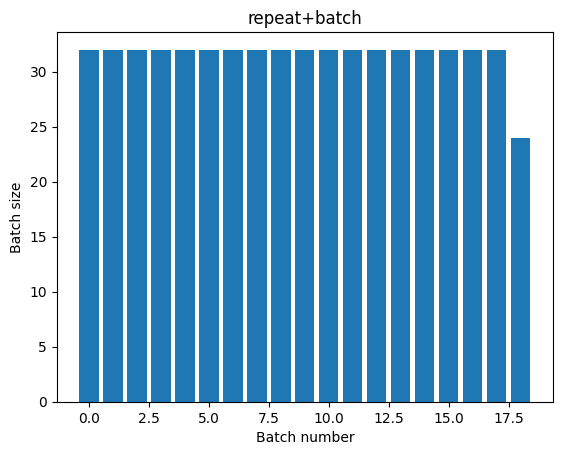

In [42]:
# plot the bar diagram of repeat+batch
repeat_batch_ds = raw_dataset.repeat(3).batch(32)
plot_batch_sizes(repeat_batch_ds,'repeat+batch')

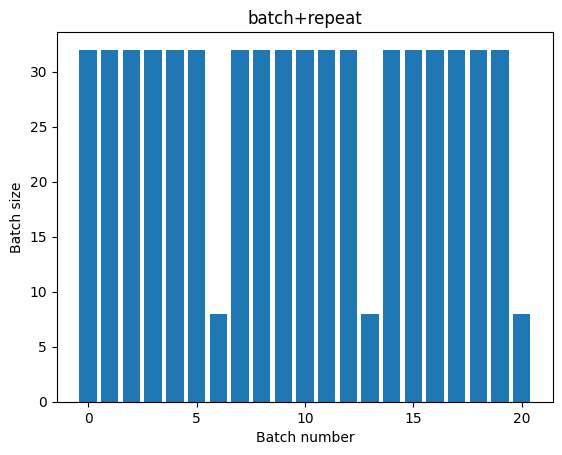

In [43]:
# plot the bar diagram of batch+repeat
batch_repeat_ds = raw_dataset.batch(32).repeat(3)
plot_batch_sizes(batch_repeat_ds,'batch+repeat')

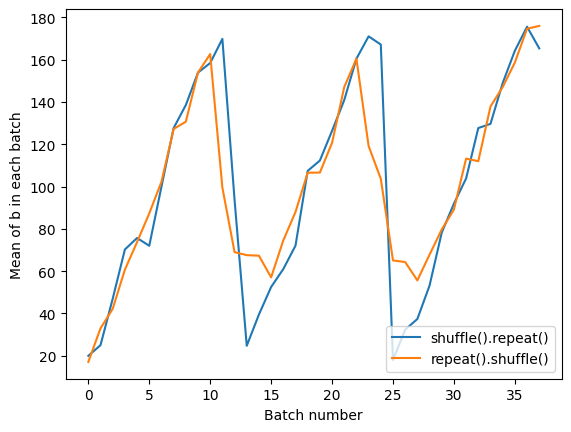

In [44]:
# shuffle + repeat / repeat + shuffle
# You can find that a repeat before a shuffle mixes the epoch boundaries in this graph.
shuffle_repeat_ds = raw_dataset.shuffle(32).repeat(3).batch(16)
repeat_shuffle_ds = raw_dataset.repeat(3).shuffle(32).batch(16)

shuffle_repeat = [batch[1].numpy().mean() for batch in shuffle_repeat_ds]
repeat_shuffle = [batch[1].numpy().mean() for batch in repeat_shuffle_ds]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.xlabel('Batch number')
plt.ylabel("Mean of b in each batch")
plt.legend()

### CNN Model for CIFAR 10

#### Loading Data Manually

In [45]:
# the url to download CIFAR-10 dataset (binary version)
# see format and details here: http://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# the image size we want to keep
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

In [46]:
# donwnload data
if not os.path.exists("cifar-10-batches-py/"): 
    cifar10 = utils.get_file('cifar-10-python.tar.gz',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = DATA_URL,
                                      extract = True)



170500096/170498071 [==============================] - 16s 0us/step


In [47]:
DEST_DIRECTORY = 'cifar-10-batches-py'
filenames_train = [os.path.join(DEST_DIRECTORY,'data_batch_%d' % i) for i in range(1,6)]
filenames_test = [os.path.join(DEST_DIRECTORY,'test_batch')]

In [48]:
# save (img_path, label) pairs
with open('cifar10_train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filenames'])
    writer.writerows(np.array(filenames_train).reshape(-1,1))
        
with open('cifar10_test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filenames'])
    writer.writerows(np.array(filenames_test).reshape(-1,1))

In [49]:
# read data
def read_file(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
@tf.function
def map_fun(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
@tf.function
def map_fun_test(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [50]:
X_train = None
Y_train = None
X_test = None
Y_test = None

for filename in filenames_train:
    image,label = read_file(filename)
    X_train = image if X_train is None else np.concatenate((X_train,image))
    Y_train = label if Y_train is None else np.concatenate((Y_train,label))

for filename in filenames_test:
    image,label = read_file(filename)
    X_test = image if X_test is None else np.concatenate((X_test,image))
    Y_test = label if Y_test is None else np.concatenate((Y_test,label))

# Construct training Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train)).map(map_fun).shuffle(10000).batch(64)

# # Construct testing Dataset
dataset_test = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).map(map_fun_test).batch(64)

In [51]:
model_cifar = models.Sequential()

model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Flatten())
model_cifar.add(layers.Dense(384, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(192, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(10, activation='softmax'))

In [52]:
model_cifar.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_cifar.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 64)        4864      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        102464    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

In [53]:
model_cifar.fit(dataset, epochs=5, validation_data=dataset_test, verbose=1)
_, test_acc = model_cifar.evaluate(dataset_test, verbose=0)
print('test accuracy:',test_acc)

Epoch 1/5
782/782 [==============================] - 13s 14ms/step - loss: 1.7853 - accuracy: 0.3712 - val_loss: 1.3321 - val_accuracy: 0.5306
Epoch 2/5
782/782 [==============================] - 11s 13ms/step - loss: 1.3525 - accuracy: 0.5251 - val_loss: 1.1171 - val_accuracy: 0.6146
Epoch 3/5
782/782 [==============================] - 11s 13ms/step - loss: 1.1901 - accuracy: 0.5909 - val_loss: 1.0273 - val_accuracy: 0.6487
Epoch 4/5
782/782 [==============================] - 11s 13ms/step - loss: 1.0830 - accuracy: 0.6285 - val_loss: 0.9080 - val_accuracy: 0.6933
Epoch 5/5
782/782 [==============================] - 11s 13ms/step - loss: 1.0031 - accuracy: 0.6605 - val_loss: 0.8487 - val_accuracy: 0.7130
test accuracy: 0.7129999995231628


### Optimization for input pipeline

#### Dataset with time

In [54]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(3072), dtype=tf.float32), # img: 32*32*3
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        filenames = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file
        read_enter = time.perf_counter()
        imgs, label = [], []
        for filename in filenames:
            tmp_imgs, tmp_label = read_file(filename)
            imgs.append(tmp_imgs)
            label.append(tmp_label)
        imgs = tf.concat(imgs, axis=0)
        label = tf.concat(label, axis=0)
        read_elapsed = (time.perf_counter() - read_enter) / imgs.shape[0]
        
        for sample_idx in range(imgs.shape[0]):
            read_enter = read_enter if sample_idx == 0 else time.perf_counter()
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                imgs[sample_idx],
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [55]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    filenames = rows['filenames']
    return filenames

def read_file(filename):
    with open(filename, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'], raw_data[b'labels']

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('cifar10_train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('cifar10_test.csv', open_file, read_file)

for i in tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).take(2):
    print(i)
    print("now time", time.perf_counter())
    print("-------------------------------------------------------------------------------")

(<tf.Tensor: shape=(2, 1), dtype=string, numpy=
array([[b'Open'],
       [b'Read']], dtype=object)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2.0811821e+03, 1.8042700e-02],
       [2.0812002e+03, 4.7666281e-06]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 0,  0, -1],
       [ 0,  0,  0]])>, <tf.Tensor: shape=(3072,), dtype=float32, numpy=array([ 59.,  43.,  50., ..., 140.,  84.,  72.], dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=6>)
now time 2081.4417155
-------------------------------------------------------------------------------
(<tf.Tensor: shape=(2, 1), dtype=string, numpy=
array([[b'Open'],
       [b'Read']], dtype=object)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.0000000e+00, -1.0000000e+00],
       [ 2.0814421e+03,  4.7666281e-06]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 0,  0, -1],
       [ 0,  0,  1]])>, <tf.Tensor: shape=(3072,), dtype=float32, numpy=array([154., 12

### Map function with time

In [56]:
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32)
        )
    return wrapper

@map_decorator
def map_fun_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    # record the enter time into map_fun()
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    # distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

In [57]:
for i in tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).take(2):
    print(i)
    print("now time", time.perf_counter())
    print("-------------------------------------------------------------------------------")

(<tf.Tensor: shape=(3, 1), dtype=string, numpy=
array([[b'Open'],
       [b'Read'],
       [b'Map']], dtype=object)>, <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[2.0816919e+03, 2.9648000e-03],
       [2.0816948e+03, 5.3871941e-06],
       [2.0820259e+03, 2.4970001e-02]], dtype=float32)>, <tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 1,  0, -1],
       [ 1,  0,  0],
       [ 1,  0,  0]])>, <tf.Tensor: shape=(24, 24, 3), dtype=float32, numpy=
array([[[ 0.49025875, -0.35376313, -1.1997801 ],
        [ 0.54795456, -0.28164047, -1.1276574 ],
        [ 0.6921884 , -0.16626036, -1.0555463 ],
        ...,
        [ 0.44698977, -0.41145894, -1.2863296 ],
        [ 0.59122354, -0.2960673 , -1.1997801 ],
        [ 0.6056504 , -0.31049415, -1.2863296 ]],

       [[ 0.5046856 , -0.33933628, -1.1997801 ],
        [ 0.47583193, -0.33933628, -1.1997801 ],
        [ 0.6489194 , -0.19510251, -1.0843885 ],
        ...,
        [ 0.38929397, -0.42588577, -1.2863296 ],
        [ 0.4037

In [58]:
steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

start_time = time.perf_counter()
print("start time: ", start_time)

for steps, times, values, image, label in tqdm(tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).take(10)):    
    steps_acc = tf.concat((steps_acc, steps), axis=0)
    times_acc = tf.concat((times_acc, times), axis=0)
    values_acc = tf.concat((values_acc, values), axis=0)

    # simulate training time
    train_enter = time.perf_counter()
    time.sleep(0.1)
    train_elapsed = time.perf_counter() - train_enter
    
    steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
    times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
    values_acc = tf.concat((values_acc, [values[-1]]), axis=0)

tf.print("Execution time:", time.perf_counter() - start_time)
timeline = {"steps": steps_acc, "times": times_acc, "values": values_acc}

start time:  2082.1636733


10it [00:02,  4.80it/s]

Execution time: 2.1371367000001555


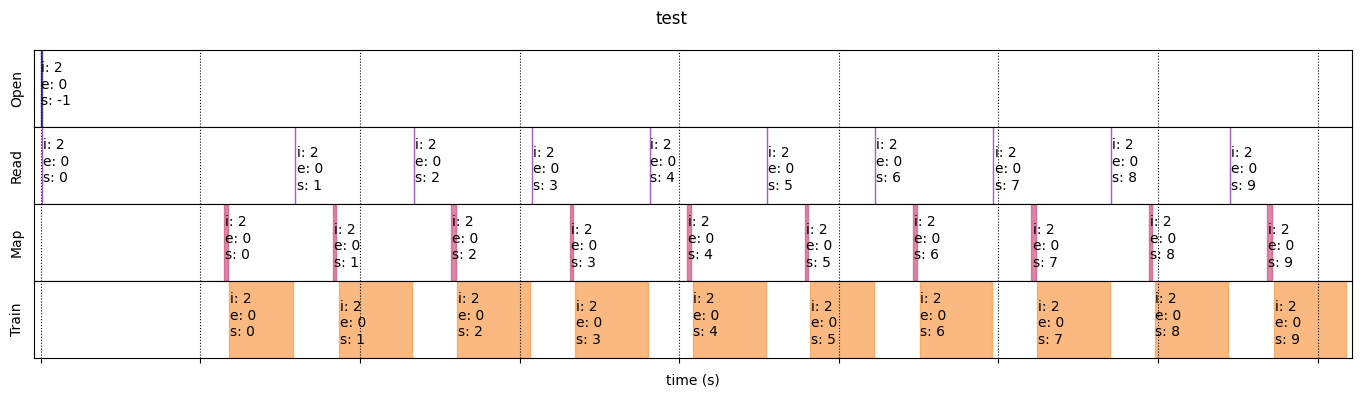

In [59]:
from lab11_1_lib import draw_timeline

draw_timeline(timeline=timeline, title="test", min_width=1, annotate=True)

In [60]:
steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

start_time = time.perf_counter()
print("start time: ", start_time)

for steps, times, values, image, label in tqdm(tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).batch(64).take(2)):
    '''
        steps: shape=(64, 3, 1)
        times: shape=(64, 3, 2)
        vaules: shape=(64, 3, 3)
        image: shape=(64, 24, 24, 3)
        label: shape=(64, 10)
    '''
    
    steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
    times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
    values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

    train_enter = time.perf_counter()
    time.sleep(0.5) # simulate training time
    train_elapsed = time.perf_counter() - train_enter
    
    train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
    
    steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
    times_acc = tf.concat([times_acc, train_time], axis=0)
    values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

tf.print("Execution time:", time.perf_counter() - start_time)
timeline = {"steps": steps_acc, "times": times_acc, "values": values_acc}

start time:  2084.8020439


2it [00:08,  4.36s/it]

Execution time: 8.78581579999991


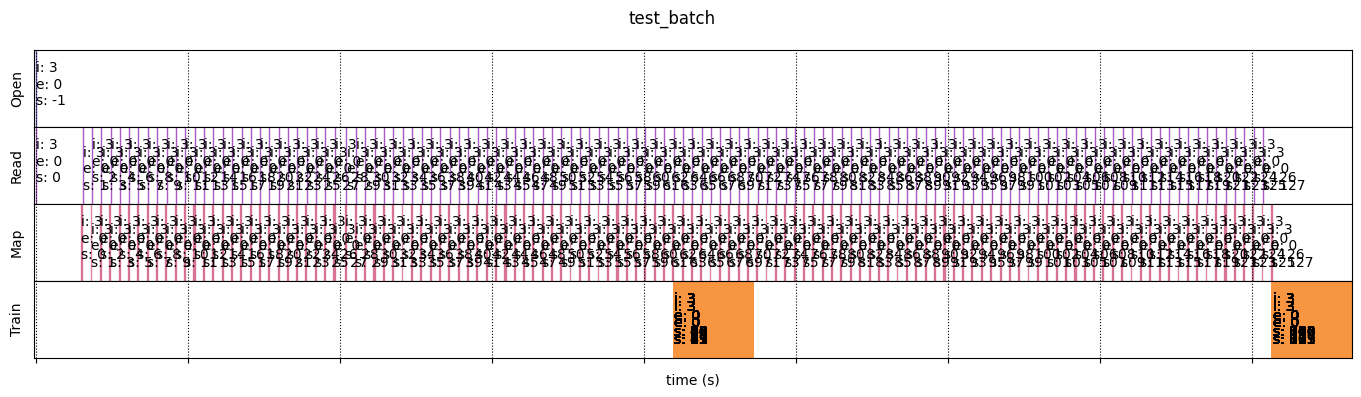

In [61]:
draw_timeline(timeline=timeline, title="test_batch", min_width=1, annotate=True)

### Re-train CNN with time

In [62]:
# re-construct a same model
model_cifar_op = models.Sequential()

model_cifar_op.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar_op.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar_op.add(layers.BatchNormalization())
                
model_cifar_op.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar_op.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar_op.add(layers.BatchNormalization())
                
model_cifar_op.add(layers.Flatten())
model_cifar_op.add(layers.Dense(384, activation='relu'))
model_cifar_op.add(layers.Dropout(0.5))
model_cifar_op.add(layers.Dense(192, activation='relu'))
model_cifar_op.add(layers.Dropout(0.5))
model_cifar_op.add(layers.Dense(10, activation='softmax'))
model_cifar_op.build()
model_cifar_op.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 64)        4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

In [63]:
# save the initialization of weights 
model_cifar_op.save_weights('model_cifar_op.h5')

In [64]:
# define loss and optimizer
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [65]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model_cifar_op(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model_cifar_op.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_cifar_op.trainable_variables))

    train_loss(loss)
    train_accuracy(tf.argmax(label,axis=1), predictions)
    
@tf.function
def test_step(image, label):
    predictions = model_cifar_op(image, training=False)
    t_loss = loss_object(label, predictions)

    test_loss(t_loss)
    test_accuracy(tf.argmax(label,axis=1), predictions)

In [66]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(50000/BATCH_SIZE)):
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(10000/BATCH_SIZE)):
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [ ]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Construct training Dataset with similar steps
dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .map(map_fun_with_time)\
                                        .shuffle(10000)\
                                        .batch(BATCH_SIZE, drop_remainder=True)
                                        
# Construct testing Dataset with similar steps
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                       .map(map_fun_test_with_time)\
                                       .batch(BATCH_SIZE, drop_remainder=True)

timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=2)

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=8500)

#### optimization dataset pipeline

In [68]:
@map_decorator
def map_fun_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [69]:
dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

# load the same initialization of weights and re-train with optimized input pipeline
model_cifar_op.load_weights('model_cifar_op.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=2)

start time:  3250.2534517
training:


100%|██████████| 781/781 [01:43<00:00,  7.51it/s]

testing:



100%|██████████| 156/156 [00:19<00:00,  7.83it/s]

Epoch 1, Loss: 1.8882, Accuracy: 32.2143, test Loss: 1.5047, test Accuracy: 45.8033
training:



100%|██████████| 781/781 [01:37<00:00,  7.98it/s]

testing:



100%|██████████| 156/156 [00:20<00:00,  7.78it/s]

Epoch 2, Loss: 1.5077, Accuracy: 46.2188, test Loss: 1.2460, test Accuracy: 56.5304
Execution time: 241.8322373000001


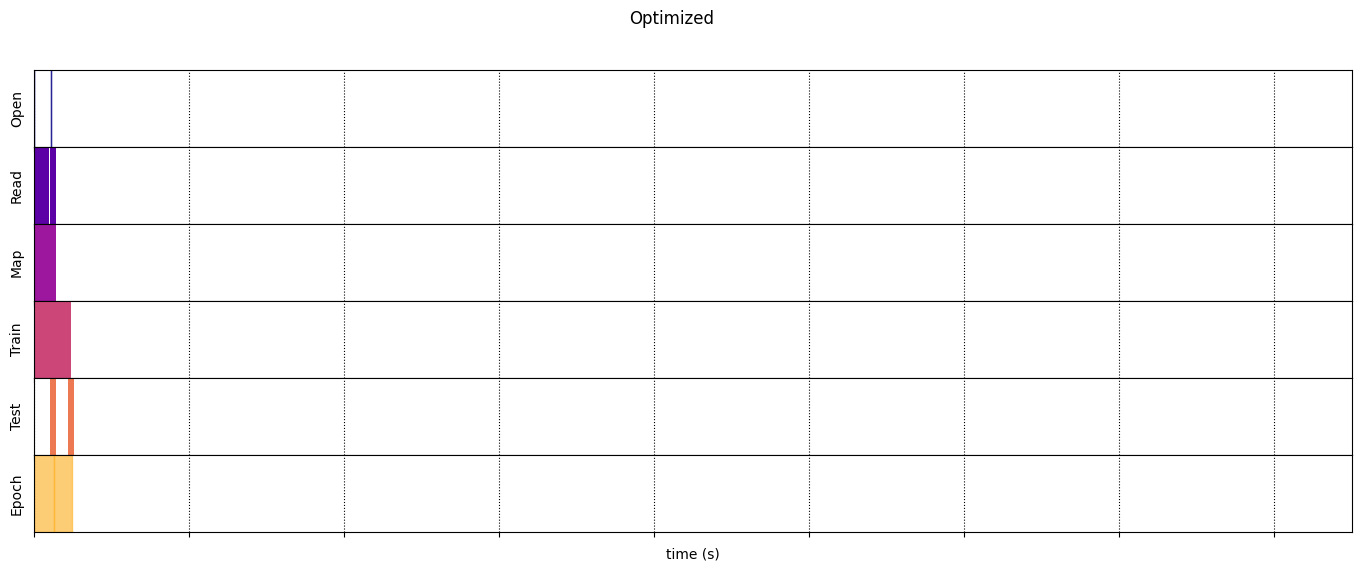

In [70]:
draw_timeline(timeline_Optimized, "Optimized", min_width=8500)

#### In practical use (a simple demo)

In [ ]:
# if files have been opened and read into memory
dataset_train_example = tf.data.Dataset.from_tensor_slices((image, label))\
                                       .shuffle(BUFFER_SIZE)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                       .cache()\
                                       .prefetch(tf.data.AUTOTUNE)

# or giving file path with `ImageDataGenerator()`, e.g.
flowers_file_path = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_image/flower_photos.tgz', untar=True)
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
dataset_train_example = tf.data.Dataset.from_generator(
                            lambda: img_gen.flow_from_directory(flowers_file_path),
                            output_types=(tf.float32, tf.float32),
                            output_shapes=([32,256,256,3], [32,5])
                        )
dataset_train_example = dataset_train_example.shuffle(BUFFER_SIZE)\
                                             .batch(BATCH_SIZE, drop_remainder=True)\
                                             .map(map_fun_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                             .cache()\
                                             .prefetch(tf.data.AUTOTUNE)

# or tf.data.Dataset.list_files()
dataset_train_example = tf.data.Dataset.list_files(flowers_file_path+"/*/*.jpg")\
                                       .shuffle(BUFFER_SIZE)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                       .cache()\
                                       .prefetch(tf.data.AUTOTUNE)

### <center>Assignment</center>

In this assignment, you have to implement the input pipeline of the CNN model and try to write/read tfrecord with the **Oregon Wildlife** dataset.

We provide you with the complete code for the image classification task of the CNN model, but remove the part of the input pipeline. What you need to do is completing this part and training the model for at least 5 epochs.

**Description of Dataset:**

1. The raw data is from [kaggle](https://www.kaggle.com/virtualdvid/oregon-wildlife), which consists of 20 class image of wildlife.
2. We have filtered the raw data. You need to download the filtered image from [here](https://drive.google.com/file/d/1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx/view?usp=sharing) and use them to complete the image classification task.
3. In the dataset we prepared for you, there are nearly 7,200 image, which contain **10 kinds** of wildlife.

The sample image is shown below:

![](https://nthu-datalab.github.io/ml/labs/11-1_CNN/imgsrc/red_fox.png)

#### Requirement:

- Try some the input transfromation mentioned above (e.g. shuffle, batch, repeat, map(random_crop, random_flip_left_right, ...)) but without optimization terms (e.g. prefetch, cache, num_parallel_calls)
    - Compare the performance and time consumption to the Naive one.
    - Note that it's important to take some examples and plot the image like block [84] to make sure theat the map function does as you desired
- Retrain your model with optimized terms, comparing the performance and time consumption.
- Training both models above for at least 3 epochs.
- Briefly summarize what you did and explain the performance results (accuracy and time consuming).
    - It's fine if you get worse performace after applying input transfromation, or get longer time consumption after applying data pipeline optimization. Just try to analyze the result and propose your assumption, e.g.
        - Is it possible that the more difficult training data after input transfromation may need more epochs to train to get better performance?
        - Which step is the bottleneck on your device? Why? Any other steps cost more time than your expect?


#### Note:

The `time.sleep(0.05)` in the example is to avoid concurrency issues that TAs are unable to solve at short notice. However, the duration **depends on devices** (the throughput between CPU and GPU maybe). For example, in our lab servers, 0.05 is enough for one newer computer while another computer still sometimes meet the error even we increase to 0.1. Therefore, if you meet strange errors like below and **not always meets the error when re-run the same code**, setting higher sleep time may help though it's slower. Errors that TA meets:

- `Expected size[1] in [0, 101], but got 224 [Op:Slice]` when `tf.image.random_crop(image, [tf.shape(image)[0],IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])`
- `ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [196,3] vs. shape[1] = [3,3] [Op:ConcatV2] name: concat` when `tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)`
- `Expected multiples argument to be a vector of length 1 but got length 3 [Op:Tile]` when `values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)`

#### Notification:

- Submit to **eeclass** with your ipynb (Lab11-1_{student_id}.ipynb)
- Deadline: 2023-11-9 (Thr) 23:59


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [ ]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

In [ ]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [ ]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

In [ ]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

In [ ]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

In [ ]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

In [ ]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [ ]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [ ]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [ ]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [ ]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [ ]:
wild_model.summary()

In [ ]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [ ]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

In [ ]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map

# dataset_train_augmentation = tf.data.Dataset.range(1). ...
# dataset_test_augmentation = tf.data.Dataset.range(1). ...

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

In [ ]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

In [ ]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

In [ ]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=3000)